## TorchRec Practice
Sung Min Cho (tjdals4565@gmail.com)

## Goals

- To understand realistic recommendation systems and their workloads
- To understand industrial solutions for large-scale recommendation systems


## Setups

In [1]:
# make sure to change the runtime type to gpu
!nvidia-smi

Wed Aug 10 15:43:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8    15W /  N/A |   1545MiB /  8192MiB |     21%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
!pip install torchrec

     -------------------------------------- 293.4/293.4 kB 9.1 MB/s eta 0:00:00
  Using cached docker-5.0.3-py2.py3-none-any.whl (146 kB)
     ---------------------------------------- 141.2/141.2 kB ? eta 0:00:00
  Using cached cmake-3.24.0-py2.py3-none-win_amd64.whl (39.7 MB)
  Using cached pyDeprecate-0.3.2-py3-none-any.whl (10 kB)
  Using cached scikit_build-0.15.0-py2.py3-none-any.whl (77 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached docstring_parser-0.14.1-py3-none-any.whl (33 kB)
  Using cached typing_inspect-0.7.1-py3-none-any.whl (8.4 kB)
     --------------------------------------- 19.5/19.5 MB 18.7 MB/s eta 0:00:00
  Using cached mypy_extensions-0.4.3-py2.py3-none-any.whl (4.5 kB)
     ---------------------------------------- 42.2/42.2 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tabulate-0.8.10-py3-none-any.whl (29 kB)
     -------------------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\AI_15\\.conda\\envs\\samsung_ai\\Lib\\site-packages\\win32\\_win32sysloader.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
#!apt-get install unzip

In [4]:
!pip3 install pandas implicit sklearn onnx "git+https://github.com/mlperf/logging.git" surgeon-pytorch pandas scipy

  Cloning https://github.com/mlperf/logging.git to c:\users\ai_15\appdata\local\temp\pip-req-build-n8ptqbkf
  Resolved https://github.com/mlperf/logging.git to commit bebd46b899c13cc0aec5ea5da2fd4ed3ec1deded
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 630.1/630.1 kB 13.2 MB/s eta 0:00:00
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 11.5/11.5 MB 18.2 MB/s eta 0:00:00
  Using cached surgeon_pytorch-0.0.4-py3-none-any.whl (6.1 kB)
     ---------------------------------------- 7.1/7.1 MB 18.9 MB/s eta 0:00:00
     ------------------------------------- 905.1/905.1 kB 19.0 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp37-cp37m-win_amd64.whl (153 kB)
  Using cached data_science_types-0.2.23-py3-none-any.whl (42 kB)
  Using cached joblib-1.1.0-py2.py3-n

  Running command git clone --filter=blob:none --quiet https://github.com/mlperf/logging.git 'C:\Users\AI_15\AppData\Local\Temp\pip-req-build-n8ptqbkf'


In [5]:
import multiprocess
import os
import pickle
import random
from pathlib import Path
from typing import *

import torchrec
import fbgemm_gpu
import torch
import torch.nn as nn
import surgeon_pytorch
import numpy as np
import math
import scipy.sparse as sparse
import implicit
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.auto import tqdm, trange
from scipy.sparse import csr_matrix, save_npz, load_npz

ModuleNotFoundError: No module named 'multiprocess'

## (1) Model Authoring

### DLRM

#### DLRM in conventional PyTorch code

In [ ]:
!git clone https://github.com/facebookresearch/dlrm

Cloning into 'dlrm'...
remote: Enumerating objects: 638, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 638 (delta 37), reused 50 (delta 29), pack-reused 578
Receiving objects: 100% (638/638), 1.34 MiB | 8.03 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [ ]:
cd dlrm

/content/dlrm


In [ ]:
import dlrm_s_pytorch as s

<img src="https://user-images.githubusercontent.com/8216334/166137804-dba9f58a-fb9f-403b-b46c-efff9a8266ef.png" width=500>

In [ ]:
dlrm = s.DLRM_Net(
    m_spa=16,
    ln_emb=np.array([100,100]),
    ln_bot=np.array([13,64,16]),
    ln_top=np.array([19,16,8,4,1]),
    arch_interaction_op="dot",
    arch_interaction_itself=False,
    qr_flag=False,
    md_flag=False,
)

In [ ]:
dlrm

DLRM_Net(
  (emb_l): ModuleList(
    (0): EmbeddingBag(100, 16, mode=sum)
    (1): EmbeddingBag(100, 16, mode=sum)
  )
  (bot_l): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (top_l): Sequential(
    (0): Linear(in_features=19, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): ReLU()
  )
  (loss_fn): BCELoss()
)

In [ ]:
# run training
!python dlrm_s_pytorch.py --arch-sparse-feature-size=16 --arch-embedding-size="100-100" --arch-mlp-bot="13-64-16" --arch-mlp-top="16-8-4-1" \
                          --data-generation random --mini-batch-size=2 --data-size=10 \
                          --use-gpu \

world size: 1, current rank: 0, local rank: 0
Using 1 GPU(s)...
time/loss/accuracy (if enabled):
Finished training it 1/5 of epoch 0, -1.00 ms/it, loss 0.207687
Finished training it 2/5 of epoch 0, -1.00 ms/it, loss 0.091614
Finished training it 3/5 of epoch 0, -1.00 ms/it, loss 0.073226
Finished training it 4/5 of epoch 0, -1.00 ms/it, loss 0.039275
Finished training it 5/5 of epoch 0, -1.00 ms/it, loss 0.009234


#### Let's try authoring DLRM in TorchRec style

In [ ]:
from torchrec.models.dlrm import DLRM, DLRMTrain

#### Most notable difference is the need to use EmbeddingBagCollection module. This enables sharding of embedding tabels and hence model parallelism.

In [ ]:
eb1_config = torchrec.EmbeddingBagConfig(
    name="t1", embedding_dim=16, num_embeddings=100, feature_names=["f1"],
)
eb2_config = torchrec.EmbeddingBagConfig(
    name="t2", embedding_dim=16, num_embeddings=100, feature_names=["f2"],
)

ebc = torchrec.EmbeddingBagCollection(tables=[eb1_config, eb2_config])

In [ ]:
sparse_features = torchrec.KeyedJaggedTensor.from_offsets_sync(
    keys=["f1", "f2"],
    values=torch.tensor([1, 2, 4, 5, 4, 3, 2, 9, 1]),
    offsets=torch.tensor([0, 2, 4, 6, 9]),
)

In [ ]:
sparse_features.to_dict()

{'f1': <torchrec.sparse.jagged_tensor.JaggedTensor at 0x7f39965dbb50>,
 'f2': <torchrec.sparse.jagged_tensor.JaggedTensor at 0x7f39960b2590>}

In [ ]:
sparse_features.to_dict()["f1"].to_dense(), sparse_features.to_dict()["f2"].to_dense()

([tensor([1, 2]), tensor([4, 5])], [tensor([4, 3]), tensor([2, 9, 1])])

In [ ]:
output = ebc(sparse_features)
output

In [ ]:
output.to_dict()

{'f1': tensor([[-0.1160,  0.1060,  0.8272, -2.1446,  2.3160,  1.0256,  1.7288, -3.2980,
          -0.4459,  0.8593,  0.7738, -0.3486, -1.2623, -0.9619, -1.9817, -1.0836],
         [-0.4917,  0.7469,  0.9562,  2.1484, -0.9013,  0.0701,  1.8020, -1.0975,
          -1.0246,  0.2084, -1.6990, -0.9272, -0.1179, -1.9237, -0.0484,  1.3282]],
        grad_fn=<SplitWithSizesBackward0>),
 'f2': tensor([[ 9.0085e-01,  1.4912e-01,  3.6390e+00, -3.3108e+00, -2.6895e-01,
           1.6424e+00,  3.3362e+00, -1.3634e+00, -1.5322e+00, -2.9653e-01,
           2.9401e-01, -1.1245e+00, -4.6298e-01, -4.8086e-01,  3.3310e-01,
           6.4788e-01],
         [-1.7936e+00, -3.0238e+00, -1.6895e+00, -3.2404e-01, -3.2737e-03,
          -3.7352e+00, -3.1803e-01, -1.9177e+00, -1.0937e+00, -3.6570e+00,
           3.5623e+00, -1.5626e-01, -8.2635e-01,  1.5135e+00, -4.0056e-01,
           7.4349e-01]], grad_fn=<SplitWithSizesBackward0>)}

In [ ]:
torchrec_dlrm = DLRM(
    embedding_bag_collection = ebc,
    dense_in_features = 13,
    dense_arch_layer_sizes=[64,16],
    over_arch_layer_sizes=[16,8,4,1],
)

In [ ]:
torchrec_dlrm

DLRM(
  (sparse_arch): SparseArch(
    (embedding_bag_collection): EmbeddingBagCollection(
      (embedding_bags): ModuleDict(
        (t1): EmbeddingBag(100, 16, mode=sum)
        (t2): EmbeddingBag(100, 16, mode=sum)
      )
    )
  )
  (dense_arch): DenseArch(
    (model): MLP(
      (_mlp): Sequential(
        (0): Perceptron(
          (_linear): Linear(in_features=13, out_features=64, bias=True)
        )
        (1): Perceptron(
          (_linear): Linear(in_features=64, out_features=16, bias=True)
        )
      )
    )
  )
  (inter_arch): InteractionArch()
  (over_arch): OverArch(
    (model): Sequential(
      (0): MLP(
        (_mlp): Sequential(
          (0): Perceptron(
            (_linear): Linear(in_features=19, out_features=16, bias=True)
          )
          (1): Perceptron(
            (_linear): Linear(in_features=16, out_features=8, bias=True)
          )
          (2): Perceptron(
            (_linear): Linear(in_features=8, out_features=4, bias=True)
        

In [ ]:
# a little exercise: fix the dense features so that the forward call works!
# hint: dense features should be the shape of Batch Size x Dense Feature Dim

dense_features = None
sparse_features = torchrec.KeyedJaggedTensor.from_offsets_sync(
    keys=["f1", "f2"],
    values=torch.tensor([1, 2, 4, 5, 4, 3, 2, 9]),
    offsets=torch.tensor([0, 2, 4, 6, 8]),
)

torchrec_dlrm(dense_features, sparse_features)

TypeError: ignored

## (2) Sharding

### Sharding in traditional DLRM code

<img src="https://user-images.githubusercontent.com/8216334/166138023-316065aa-c7e0-481e-a12a-0ebb6ac06549.png" width=500>

In [ ]:
def forward(self, dense_x, lS_o, lS_i):
    if ext_dist.my_size > 1:
        # multi-node multi-device run
        return self.distributed_forward(dense_x, lS_o, lS_i)
    elif self.ndevices <= 1:
        # single device run
        return self.sequential_forward(dense_x, lS_o, lS_i)
    else:
        # single-node multi-device run
        return self.parallel_forward(dense_x, lS_o, lS_i)

**For example, look how distributed_forward is implemented manually below**

In [ ]:
def distributed_forward(self, dense_x, lS_o, lS_i):
        batch_size = dense_x.size()[0]
        # WARNING: # of ranks must be <= batch size in distributed_forward call
        if batch_size < ext_dist.my_size:
            sys.exit(
                "ERROR: batch_size (%d) must be larger than number of ranks (%d)"
                % (batch_size, ext_dist.my_size)
            )
        if batch_size % ext_dist.my_size != 0:
            sys.exit(
                "ERROR: batch_size %d can not split across %d ranks evenly"
                % (batch_size, ext_dist.my_size)
            )

        dense_x = dense_x[ext_dist.get_my_slice(batch_size)]
        lS_o = lS_o[self.local_emb_slice]
        lS_i = lS_i[self.local_emb_slice]

        if (len(self.emb_l) != len(lS_o)) or (len(self.emb_l) != len(lS_i)):
            sys.exit(
                "ERROR: corrupted model input detected in distributed_forward call"
            )

        # embeddings
        with record_function("DLRM embedding forward"):
            ly = self.apply_emb(lS_o, lS_i, self.emb_l, self.v_W_l)

        # WARNING: Note that at this point we have the result of the embedding lookup
        # for the entire batch on each rank. We would like to obtain partial results
        # corresponding to all embedding lookups, but part of the batch on each rank.
        # Therefore, matching the distribution of output of bottom mlp, so that both
        # could be used for subsequent interactions on each device.
        if len(self.emb_l) != len(ly):
            sys.exit("ERROR: corrupted intermediate result in distributed_forward call")

        a2a_req = ext_dist.alltoall(ly, self.n_emb_per_rank)

        with record_function("DLRM bottom nlp forward"):
            x = self.apply_mlp(dense_x, self.bot_l)

        ly = a2a_req.wait()
        ly = list(ly)

        # interactions
        with record_function("DLRM interaction forward"):
            z = self.interact_features(x, ly)

        # top mlp
        with record_function("DLRM top nlp forward"):
            p = self.apply_mlp(z, self.top_l)

        # clamp output if needed
        if 0.0 < self.loss_threshold and self.loss_threshold < 1.0:
            z = torch.clamp(p, min=self.loss_threshold, max=(1.0 - self.loss_threshold))
        else:
            z = p

        return z

#### (Optional) Embedding Table Compression Techniques

In [ ]:
import tricks.qr_embedding_bag as qr
qr_emb = qr.QREmbeddingBag(num_categories=100, embedding_dim=16, num_collisions=3)

# 100*16 => 34*16 + 3*16
qr_emb.weight_q.shape, qr_emb.weight_r.shape

(torch.Size([34, 16]), torch.Size([3, 16]))

In [ ]:
sparse_offsets = [torch.LongTensor([0,4]), torch.LongTensor([0,3])]
sparse_indices = [torch.LongTensor([10,20,30,40,50,60,70]), torch.LongTensor([11,21,31,41,51,61,71])]

In [ ]:
qr_emb(sparse_indices[0], sparse_offsets[0]).shape

torch.Size([2, 16])

In [ ]:
!python dlrm_s_pytorch.py --arch-sparse-feature-size=16 --arch-embedding-size="100-100" --arch-mlp-bot="13-64-16" --arch-mlp-top="16-8-4-1" \
                          --data-generation random --mini-batch-size=2 --data-size=10 \
                          --use-gpu \
                          --qr-flag --qr-threshold 50 --qr-operation mult --qr-collisions 3

world size: 1, current rank: 0, local rank: 0
Using 1 GPU(s)...
time/loss/accuracy (if enabled):
Finished training it 1/5 of epoch 0, -1.00 ms/it, loss 0.095611
Finished training it 2/5 of epoch 0, -1.00 ms/it, loss 0.227742
Finished training it 3/5 of epoch 0, -1.00 ms/it, loss 0.080723
Finished training it 4/5 of epoch 0, -1.00 ms/it, loss 0.199807
Finished training it 5/5 of epoch 0, -1.00 ms/it, loss 0.693947


In [ ]:
import tricks.md_embedding_bag as md
ud_emb = md.PrEmbeddingBag(num_embeddings=100, embedding_dim=16, base_dim=16)
ud_emb

PrEmbeddingBag(
  (embs): EmbeddingBag(100, 16, mode=sum)
  (proj): Identity()
)

In [ ]:
md_emb = md.PrEmbeddingBag(num_embeddings=100, embedding_dim=8, base_dim=16)
md_emb

PrEmbeddingBag(
  (embs): EmbeddingBag(100, 8, mode=sum)
  (proj): Linear(in_features=8, out_features=16, bias=False)
)

In [ ]:
md_emb(sparse_indices[0], sparse_offsets[0]).shape

torch.Size([2, 16])

In [ ]:
md.md_solver(
    torch.Tensor([100,200,300,400]),
    alpha=0.3,
    d0=128,
    round_dim=False,
)

tensor([128, 104,  92,  84])

In [ ]:
md.md_solver(
    torch.Tensor([100,200,300,400]),
    alpha=0.3,
    B=128000,
    round_dim=False,
)

tensor([172, 140, 124, 114])

In [ ]:
172 * 100 + 140 * 200 + 124 * 300 + 114 * 400

128000

In [ ]:
!python dlrm_s_pytorch.py --arch-sparse-feature-size=16 --arch-embedding-size="100-100" --arch-mlp-bot="13-64-16" --arch-mlp-top="16-8-4-1" \
                          --data-generation random --mini-batch-size=2 --data-size=10 \
                          --use-gpu \
                          --md-flag --md-threshold 50 --md-temperature 0.3

world size: 1, current rank: 0, local rank: 0
Using 1 GPU(s)...
time/loss/accuracy (if enabled):
Finished training it 1/5 of epoch 0, -1.00 ms/it, loss 0.207687
Finished training it 2/5 of epoch 0, -1.00 ms/it, loss 0.091614
Finished training it 3/5 of epoch 0, -1.00 ms/it, loss 0.073226
Finished training it 4/5 of epoch 0, -1.00 ms/it, loss 0.039275
Finished training it 5/5 of epoch 0, -1.00 ms/it, loss 0.009234


### Sharding in TorchRec

In [ ]:
from torchrec.datasets.criteo import DEFAULT_CAT_NAMES, DEFAULT_INT_NAMES

In [ ]:
num_embeddings_per_feature = [1000000*i for i in range(1, 27)]
num_embeddings_per_feature

[1000000,
 2000000,
 3000000,
 4000000,
 5000000,
 6000000,
 7000000,
 8000000,
 9000000,
 10000000,
 11000000,
 12000000,
 13000000,
 14000000,
 15000000,
 16000000,
 17000000,
 18000000,
 19000000,
 20000000,
 21000000,
 22000000,
 23000000,
 24000000,
 25000000,
 26000000]

In [ ]:
eb_configs = [
    torchrec.EmbeddingBagConfig(
        name=f"t_{feature_name}",
        embedding_dim=64,
        num_embeddings=num_embeddings_per_feature[feature_idx],
        feature_names=[feature_name],
    )
    for feature_idx, feature_name in enumerate(DEFAULT_CAT_NAMES)
]

In [ ]:
eb_configs

[EmbeddingBagConfig(num_embeddings=1000000, embedding_dim=64, name='t_cat_0', data_type=<DataType.FP32: 'FP32'>, feature_names=['cat_0'], weight_init_max=None, weight_init_min=None, pooling=<PoolingType.SUM: 'SUM'>),
 EmbeddingBagConfig(num_embeddings=2000000, embedding_dim=64, name='t_cat_1', data_type=<DataType.FP32: 'FP32'>, feature_names=['cat_1'], weight_init_max=None, weight_init_min=None, pooling=<PoolingType.SUM: 'SUM'>),
 EmbeddingBagConfig(num_embeddings=3000000, embedding_dim=64, name='t_cat_2', data_type=<DataType.FP32: 'FP32'>, feature_names=['cat_2'], weight_init_max=None, weight_init_min=None, pooling=<PoolingType.SUM: 'SUM'>),
 EmbeddingBagConfig(num_embeddings=4000000, embedding_dim=64, name='t_cat_3', data_type=<DataType.FP32: 'FP32'>, feature_names=['cat_3'], weight_init_max=None, weight_init_min=None, pooling=<PoolingType.SUM: 'SUM'>),
 EmbeddingBagConfig(num_embeddings=5000000, embedding_dim=64, name='t_cat_4', data_type=<DataType.FP32: 'FP32'>, feature_names=['cat

In [ ]:
train_model = DLRMTrain(
    DLRM(
        embedding_bag_collection=torchrec.EmbeddingBagCollection(
            tables=eb_configs, device=torch.device("meta")
        ),
        dense_in_features=len(DEFAULT_INT_NAMES),
        dense_arch_layer_sizes=[512,256,64],
        over_arch_layer_sizes=[512,512,256,1],
        dense_device="cuda:0",
    )
)

In [ ]:
from torchrec.distributed.model_parallel import *
from torchrec.distributed.types import *
from torchrec.distributed.planner.types import *

In [ ]:
# This colab notebook only provides one gpu so let's feed it fake topology

topology=Topology(
    world_size=4,
    compute_device="cuda", 
    hbm_cap = 34359738368,  # 32GB
    ddr_cap = 137438953472, # 128GB
)

In [ ]:
topology

world_size=4 
compute_device=cuda
devices=
	device 0 DeviceHardware(rank=0, storage=Storage(hbm=34359738368, ddr=137438953472), perf=0)
	device 1 DeviceHardware(rank=1, storage=Storage(hbm=34359738368, ddr=137438953472), perf=0)
	device 2 DeviceHardware(rank=2, storage=Storage(hbm=34359738368, ddr=137438953472), perf=0)
	device 3 DeviceHardware(rank=3, storage=Storage(hbm=34359738368, ddr=137438953472), perf=0)
local_world_size=4 
intra_host_bw=644245094.4 
inter_host_bw=13421772.8 

In [ ]:
planner = EmbeddingShardingPlanner(
    topology=topology,
)

In [ ]:
sharders = get_default_sharders()

In [ ]:
plan = planner.plan(train_model, sharders)

In [ ]:
# let's pretty print plan

def parameter_sharding_to_str(sharding: ParameterSharding) -> str:
    lines = []
    lines.append(f"  sharding_type {sharding.sharding_type}")
    lines.append(f"  compute_kernel {sharding.compute_kernel}")
    lines.append(f"  ranks {sharding.ranks}")
    sharding_spec = sharding.sharding_spec
    if sharding_spec is not None and isinstance(sharding_spec, EnumerableShardingSpec):
        shards: List[ShardMetadata] = sharding_spec.shards
        for shard in shards:
            lines.append(f"    shard_offsets {shard.shard_offsets}")
            lines.append(f"    shard_sizes {shard.shard_sizes}")
            lines.append(f"    placement {shard.placement}")
    lines.append(f"    ")
    return '\n'.join(lines)

def sharding_plan_to_str(plan: ShardingPlan) -> str:
    lines = []
    for fqn, d in plan.plan.items():
        lines.append(f"fqn={fqn}")
        for param_name, param_sharding in d.items():
            lines.append(f"param_name={param_name}")
            lines.append(parameter_sharding_to_str(param_sharding))
    return '\n'.join(lines)

In [ ]:
print(sharding_plan_to_str(plan))

fqn=model.sparse_arch.embedding_bag_collection
param_name=t_cat_0
  sharding_type table_wise
  compute_kernel fused
  ranks [1]
    shard_offsets [0, 0]
    shard_sizes [1000000, 64]
    placement rank:1/cuda:1
    
param_name=t_cat_1
  sharding_type table_wise
  compute_kernel fused
  ranks [0]
    shard_offsets [0, 0]
    shard_sizes [2000000, 64]
    placement rank:0/cuda:0
    
param_name=t_cat_2
  sharding_type table_wise
  compute_kernel fused
  ranks [3]
    shard_offsets [0, 0]
    shard_sizes [3000000, 64]
    placement rank:3/cuda:3
    
param_name=t_cat_3
  sharding_type table_wise
  compute_kernel fused
  ranks [2]
    shard_offsets [0, 0]
    shard_sizes [4000000, 64]
    placement rank:2/cuda:2
    
param_name=t_cat_4
  sharding_type table_wise
  compute_kernel fused
  ranks [1]
    shard_offsets [0, 0]
    shard_sizes [5000000, 64]
    placement rank:1/cuda:1
    
param_name=t_cat_5
  sharding_type table_wise
  compute_kernel fused
  ranks [0]
    shard_offsets [0, 0]
  

In [ ]:
# let's make it too large to fit on 1 GPU
num_embeddings_per_feature[-1] *= 5

In [ ]:
eb_configs = [
    torchrec.EmbeddingBagConfig(
        name=f"t_{feature_name}",
        embedding_dim=64,
        num_embeddings=num_embeddings_per_feature[feature_idx],
        feature_names=[feature_name],
    )
    for feature_idx, feature_name in enumerate(DEFAULT_CAT_NAMES)
]

In [ ]:
train_model = DLRMTrain(
    DLRM(
        embedding_bag_collection=torchrec.EmbeddingBagCollection(
            tables=eb_configs, device=torch.device("meta")
        ),
        dense_in_features=len(DEFAULT_INT_NAMES),
        dense_arch_layer_sizes=[512,256,64],
        over_arch_layer_sizes=[512,512,256,1],
        dense_device="cuda:0",
    )
)

In [ ]:
planner = EmbeddingShardingPlanner(
    topology=topology,
)

In [ ]:
plan = planner.plan(train_model, sharders)

In [ ]:
print(sharding_plan_to_str(plan))

fqn=model.sparse_arch.embedding_bag_collection
param_name=t_cat_0
  sharding_type row_wise
  compute_kernel fused
  ranks [0, 1, 2, 3]
    shard_offsets [0, 0]
    shard_sizes [250000, 64]
    placement rank:0/cuda:0
    shard_offsets [250000, 0]
    shard_sizes [250000, 64]
    placement rank:1/cuda:1
    shard_offsets [500000, 0]
    shard_sizes [250000, 64]
    placement rank:2/cuda:2
    shard_offsets [750000, 0]
    shard_sizes [250000, 64]
    placement rank:3/cuda:3
    
param_name=t_cat_1
  sharding_type row_wise
  compute_kernel fused
  ranks [0, 1, 2, 3]
    shard_offsets [0, 0]
    shard_sizes [500000, 64]
    placement rank:0/cuda:0
    shard_offsets [500000, 0]
    shard_sizes [500000, 64]
    placement rank:1/cuda:1
    shard_offsets [1000000, 0]
    shard_sizes [500000, 64]
    placement rank:2/cuda:2
    shard_offsets [1500000, 0]
    shard_sizes [500000, 64]
    placement rank:3/cuda:3
    
param_name=t_cat_2
  sharding_type row_wise
  compute_kernel fused
  ranks [0, 

## (3) Training

### Please do the following

(1) Open chrome and enter chrome://tracing in the address bar.

(2) Please load the `A100_4_table_wise_batched_fused_32768_128.json` file provided to you.

You should see something like the figure below.

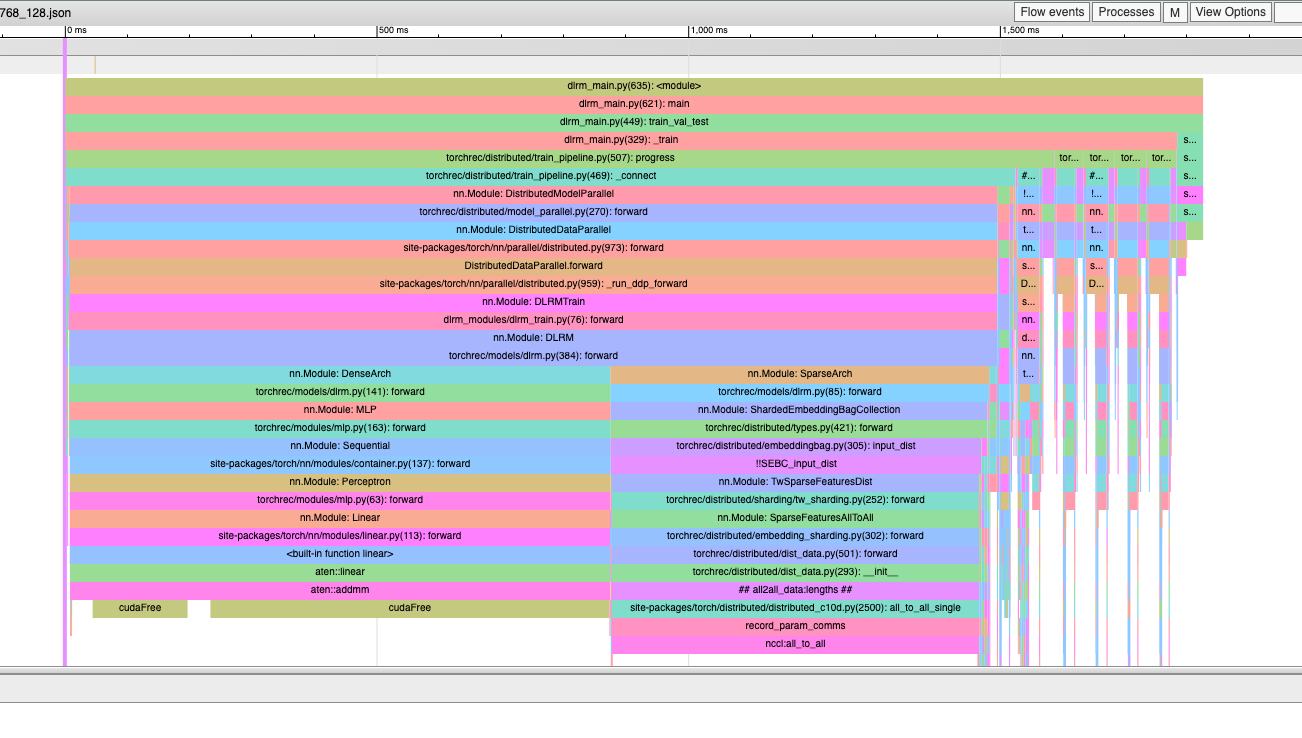

In [6]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uQ-k6lv86KXK0kRgsJw5qvFQg93s6GeI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uQ-k6lv86KXK0kRgsJw5qvFQg93s6GeI" -O wiki_p_embs.pt && rm -rf /tmp/cookies.txt

Cannot open cookies file '/tmp/cookies.txt': No such file or directory
--2022-08-10 16:30:04--  https://docs.google.com/uc?export=download&confirm=$(wget%20--quiet%20--save-cookies%20/tmp/cookies.txt%20--keep-session-cookies%20--no-check-certificate%20'https://docs.google.com/uc?export=download&id=1uQ-k6lv86KXK0kRgsJw5qvFQg93s6GeI'%20-O-%20%7C%20sed%20-rn%20's/.*confirm=([0-9A-Za-z_]+).*/%5C1%5Cn/p')&id=1uQ-k6lv86KXK0kRgsJw5qvFQg93s6GeI
Resolving docs.google.com (docs.google.com)... 142.250.207.110
Connecting to docs.google.com (docs.google.com)|142.250.207.110|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-08-10 16:30:04 ERROR 404: Not Found.

